Some examples of **problems** we may need to solve:

- **minimization**: $\arg \min_x f(x)$ for $f: \mathbb{R}^N \to \mathbb{R}$
- **interpolation**: given a function $f$, finding the function $g$ in a given space such that $f(x) = g(x)$ for $x$ in a given set (interpolation points) and such that $g$ "best" matches $f$ (Example: polynomial interpolation, spline,...)
- **solving a PDE**: finding $f$ in a given space such that $\mathcal{S}(x, f, \nabla\!f, \nabla^2\!f, \dots) = 0$
- **classification**: given inputs (images, physical quantities,...), assign a class to the input:
  - is that a kitten?!!
  - what number is written in that image?
  - red/blue points in 2D
- **regression**: finding a function $g$ in a given space that "best" matches a given set of (input, output) pairs.

In [ ]:
%matplotlib notebook

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Classification

## Red & blue dots

A first example of classification problem is **splitting the space** $\mathbb{R}^2$ in red and blue zones based on a finite sampling with a possible noise (wrong class or wrong position).

We first use Scikit-Learn to generate some sampling of following splitting:
1. two moon-shaped zones,
2. two nested circles,
3. the plan splitting by a line.

In [11]:
from sklearn.datasets import make_moons, make_circles, make_classification

# Sampling parameters
n_samples = 100
sigma = 0.3 # Noise

# Sampling shape
X_train, y_train = make_moons(n_samples=n_samples, noise=sigma, random_state=0)
#X_train, y_train = make_circles(n_samples=n_samples, noise=sigma, factor=0.5, random_state=0)
#X_train, y_train = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=0)

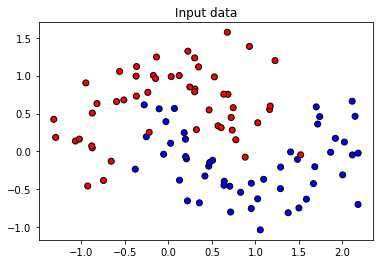

In [12]:
# Red/Blue colormap
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Plot the training points
plt.figure()
plt.title("Input data")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
plt.show()

One algorithm of classification is the **K-Nearest Neighbors**: for a given $(x,y)$ point, we found the $K$ nearest points (for a given norm) from the training dataset and we assign the most present class from these $K$ points to $(x,y)$.

$K$ is called a **hyper-parameter** of the model and choosing it appropriately is part of the problem. For example, increasing $K$ makes this algorithm more stable to outliers but a too high value can make it less efficient.

In [13]:
l1_norm = lambda x: np.linalg.norm(x, ord=1, axis=-1)
l2_norm = lambda x: np.linalg.norm(x, ord=2, axis=-1)
linf_norm = lambda x: np.linalg.norm(x, ord=np.inf, axis=-1)

# K-nearest neighbors
# Take a look at https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
# for real applications.
def kNN_predict(X_train, y_train, X_test, K=1, norm=l2_norm):
    num_test = X_test.shape[0]
    y_pred = np.empty(num_test, dtype=y_train.dtype)
    
    for i in range(num_test):
        # Distance from the current test point to the entire training set
        dist = norm(X_train - X_test[i, :])
        
        # Split the distance array by the K elements with lower value
        k_partition = np.argpartition(dist, K)
        
        # Get the classes of the K nearest elements
        nearest_class = y_train[k_partition[:K]]
        
        # Get the most common class
        knn, knn_counts = np.unique(nearest_class, return_counts=True)
        y_pred[i] = knn[np.argmax(knn_counts)]

    return y_pred

**Test dataset** is a fine Cartesian grid of the space in order to visualize the red and blue domains:

In [ ]:
# Generating test dataset as a uniform sampling of the space

# Space step
h = 0.02

# Domain bounds
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5

# Points list
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
points = np.empty((xx.size, 2))
points[:, 0] = xx.ravel()
points[:, 1] = yy.ravel()

In [ ]:
# Testing several K
for K in [1, 5, 10, 50]:
    Z = kNN_predict(X_train, y_train, points, K)

    plt.figure()
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm_bright, alpha=0.5)
    plt.title(f"K = {K}")
    plt.show()

## Image classification

Another example is the **image classification**.
The MNIST dataset contains images of handwritten digits with associated label (the corresponding digit).

The dataset is splitted in a **training** part and a **testing** part. The goal is to recognize the digits from the **testing** part given the **training** images and their labels.

The first step is to download the MNIST dataset:

In [3]:
# We use tensorflow_datasets to download the MNIST dataset
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
(mnist_trainset, mnist_testset), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to C:\Users\16007844\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\16007844\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

To accelerate the training, we only choose a subset of the training and testing dataset:

In [8]:
# Training dataset
ntrain = 12000
train_images = np.empty((ntrain, *ds_info.features['image'].shape))
train_labels = np.empty(ntrain, dtype=int)
for i, (image, label) in mnist_trainset.shuffle(60000).take(ntrain).enumerate():
    train_images[i] = image
    train_labels[i] = label

# Testing dataset
ntest = 2000
test_images = np.empty((ntest, *ds_info.features['image'].shape))
test_labels = np.empty(ntest, dtype=int)
for i, (image, label) in mnist_testset.shuffle(10000).take(ntest).enumerate():
    test_images[i] = image
    test_labels[i] = label

print(f"Number of images in the train set: {ntrain}. Size of images: {train_images[0].shape}")
print(f"Number of images in the test set: {ntest}. Size of images: {test_images[0].shape}")

Number of images in the train set: 12000. Size of images: (28, 28, 1)
Number of images in the test set: 2000. Size of images: (28, 28, 1)


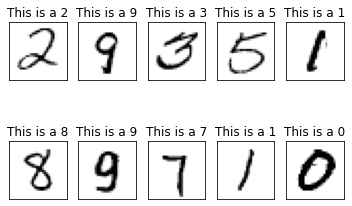

In [9]:
# Display some images from the training dataset
def show_mnist(nrow, ncol, data, targets):
    count = 0
    plt.figure()
    for i in range(nrow):
        for j in range(ncol):
            ax = plt.subplot(nrow, ncol, count + 1)
            ax.imshow(data[count, ...], cmap='Greys')
            ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
            ax.set_title(f"This is a {targets[count]}")
            count += 1
            
nrow = 2
ncol = 5
indices = np.random.choice(ntrain, nrow * ncol, replace=False)
show_mnist(2, 5, train_images[indices], train_labels[indices])

As for the "red & blue dots" problem, we propose to use the **K-nearest neighbors** method to recognize the digits.

Each image is seen as a matrix of values within $[0, 1]$ corresponding to its luminosity (0 for white, 1 for black).
The distance between two images is thus related to the **difference of luminosity for each pixel**.

One consequence is that, depending on the chosen distance, the distance between one image and a shifted version of itself can be very high.

In [14]:
# Prediction using the K-nearest Neighbors method
test_predictions = kNN_predict(
    train_images.reshape((ntrain, -1)), # Flattening the images as a 1D vector
    train_labels, 
    test_images.reshape((ntest, -1)),
    K=5,
    norm=l2_norm,
)
                

print(f"Accuracy of predictions: {np.mean(np.equal(test_predictions, test_labels)) * 100}%")

Accuracy of predictions: 95.85000000000001%


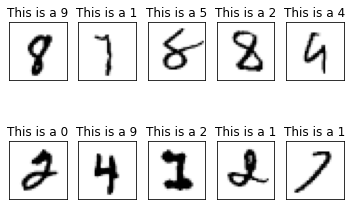

In [15]:
# Showing some predictions
nrow = 2
ncol = 5

# indices = np.arange(test_labels.size)
indices = np.argwhere(np.not_equal(test_predictions, test_labels)).ravel() # To show only wrong predictions

show_indices = np.random.choice(indices, min(indices.size, nrow * ncol), replace=False)
show_mnist(max(1, show_indices.size // 5), min(show_indices.size, 5), test_images[show_indices], test_predictions[show_indices])

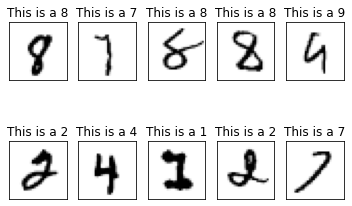

In [16]:
# Showing the right answers
show_mnist(max(1, show_indices.size // 5), min(show_indices.size, 5), test_images[show_indices], test_labels[show_indices])

# Regression

We consider a point cloud $(x_k, y_k)$ for $1 \leq i \leq K$. The goal is to fit this point cloud by a function that can be written as a linear combination of $N$ base functions (denoted by $\varphi_n$):
$$
f(x) = \sum_{n=1}^N a_n \varphi_n(x) \ .
$$
This can be done by minimizing the following function:
$$
J(\mathbf{a}) = \frac{1}{2 K} \sum_{k=1}^K \left(f(x_k) - y_k\right)^2 \ .
$$
Deriving with respect to the coefficient $a_i$:
$$
\partial_{a_i} J(\mathbf{a}) = \frac{1}{K} \sum_{k=1}^K \varphi_i(x_k) \left(f(x_k) - y_k\right) \ .
$$
A zero of the gradient of $J$ is given by the solution of the linear system:
$$
\sum_{j=1}^N \left( \frac{1}{K} \sum_{k=1}^K \varphi_i(x_k) \varphi_j(x_k) \right) a_j = \frac{1}{K} \sum_{k=1}^K y_k \varphi_i(x_k)
\quad \forall i \in \{ 1, \dots, N \} \ .
$$

For example:
- $\varphi_n(x) = x^n$, fits the point cloud by a polynomial
- Given a uniformly spaced discretization of a segment $[a, b]$ with $N$ nodes $\theta_i$, if $\varphi_n(x)$ is the hat function centered at $\theta_n$, $f$ is a piecewise affine function with $N$ points.

In [28]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

### Underlying function
We first define the **underlying function** used to generate the point cloud:

In [17]:
##### Functions used to generate a point cloud

# Polynom of given order with random roots, or given roots
def poly_from_roots(order=6, roots=None):
    if roots is None:
        roots = np.random.uniform(-2, 2, order)
    P = np.poly1d(roots, r=True, variable='X')
    return P

# Hat function
def hat(center=0, width=1, height=1):
    return lambda x: height * np.maximum(1 - 2 * np.abs(x - center) / width, 0)

# Rectangular shape with given center, width and height
def rectangular(center=0, width=1, height=1):
    return lambda x: height * (np.abs(x - center) <= width/2).astype(x.dtype)

# Sinusoidal
def sine(freq=1, phase=0, height=1):
    return lambda x: height * np.sin(2 * np.pi * freq * x + phase)

# Sawtooth
def sawtooth(freq=1, phase=0, height=1):
    return lambda x: (x % (1/freq))

# Gauss function
def gauss(mean=0, sigma=1):
    return lambda x: np.exp(-0.5 * ((x - mean)/sigma)**2)

# Sinusoidal and a line
def sinandline(freq=1, phase=0, height=1, slope=0.5):
    freq = 2*freq
    transition_point = (np.arccos(slope / (2*np.pi*freq*height)) - phase) / (2*np.pi*freq)
    sine_part = sine(freq, phase, height)
    line_part = lambda x: slope * (x - transition_point) + sine_part(transition_point)

    def fn(x):
        x_mod = (x - transition_point + 1/freq)  % (2 / freq)
        x_div = (x - transition_point + 1/freq) // (2 / freq)
        shift = x_div * slope / freq
        return np.where(x_mod <= 1/freq,
                        sine_part(x) + shift,
                        line_part(x) - shift)
    
    return fn

In [18]:
# Domain limits
xleft, xright = -1, 1

# Number of points for plots
npointplot = 1001

f = poly_from_roots()
#f = hat()
#f = rectangular()
#f = sine()
#f = sawtooth()
#f = gauss(sigma=0.1)
#f = sinandline()

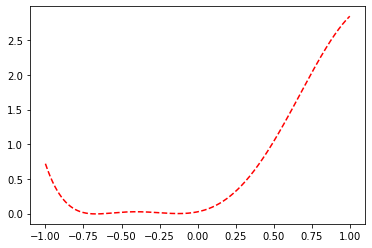

In [19]:
# Plot of the function
xx = np.linspace(xleft, xright, npointplot)
plt.figure()
plt.plot(xx, f(xx), 'r--')
plt.show()

### Point cloud

Then, we generate the associated **point cloud** with a given **noise** level:

In [20]:
# Number of points in the point cloud
npointcloud = 50

# Noise for the point cloud
sigma = 0.1

# Domain discretization
x = np.linspace(xleft, xright, npointcloud)
#x = np.random.uniform(xleft, xright, npointcloud)

# Generating the point cloud and plotting it
y = f(x)
y += sigma * np.random.randn(y.size)

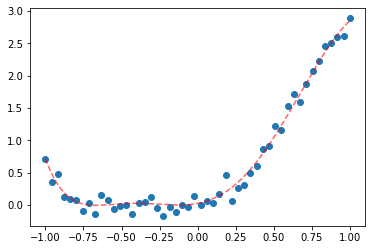

In [21]:
# Plot of the function and the point cloud
xx = np.linspace(xleft, xright, npointplot)
plt.figure()
plt.plot(xx, f(xx), 'r--', alpha=0.6)
plt.scatter(x, y)
plt.show()

### Basis functions

We define the basis functions used to fit the points $(x_k, y_k)$.

**Note:** each base functions generator return $\phi(x,i)$ and eventually the points associated to the basis

In [22]:
# Polynomial basis
def poly_basis():
    def func(x, i):
        return x**i
        #return scipy.special.eval_legendre(i, x)
    return func, None

# Hat functions centered on cartesian grid
def hat_basis(N, a, b):
    xx, dxx = np.linspace(a, b, N, retstep=True)
    def func(x, i):
        return hat(center=xx[i], width=2*dxx)(x)
    return func, xx

# Fourier basis
def fourier_basis(a, b):
    def func(x, i):
        if i & 1:
            return np.sin(np.pi * (i + 1) * x / np.abs(b - a))
        else:
            return np.cos(np.pi * i * x / np.abs(b - a))
    return func, None

# Rectangular function centered on cartesian grid
def rect_basis(N, a, b):
    xx, dxx = np.linspace(a, b, N, retstep=True)
    def func(x, i):
        return rectangular(center=xx[i], width=dxx)(x)
    return func, xx

In [39]:
# Number of basis functions
N = 11

# Choice of the function used to fit the point cloud
# xphi are the discretisation points, if any, None otherwise.
#phi, xphi = poly_basis()
#phi, xphi = hat_basis(N, xleft, xright)
#phi, xphi = fourier_basis(xleft, xright)
phi, xphi = rect_basis(N, xleft, xright)

<IPython.core.display.Javascript object>


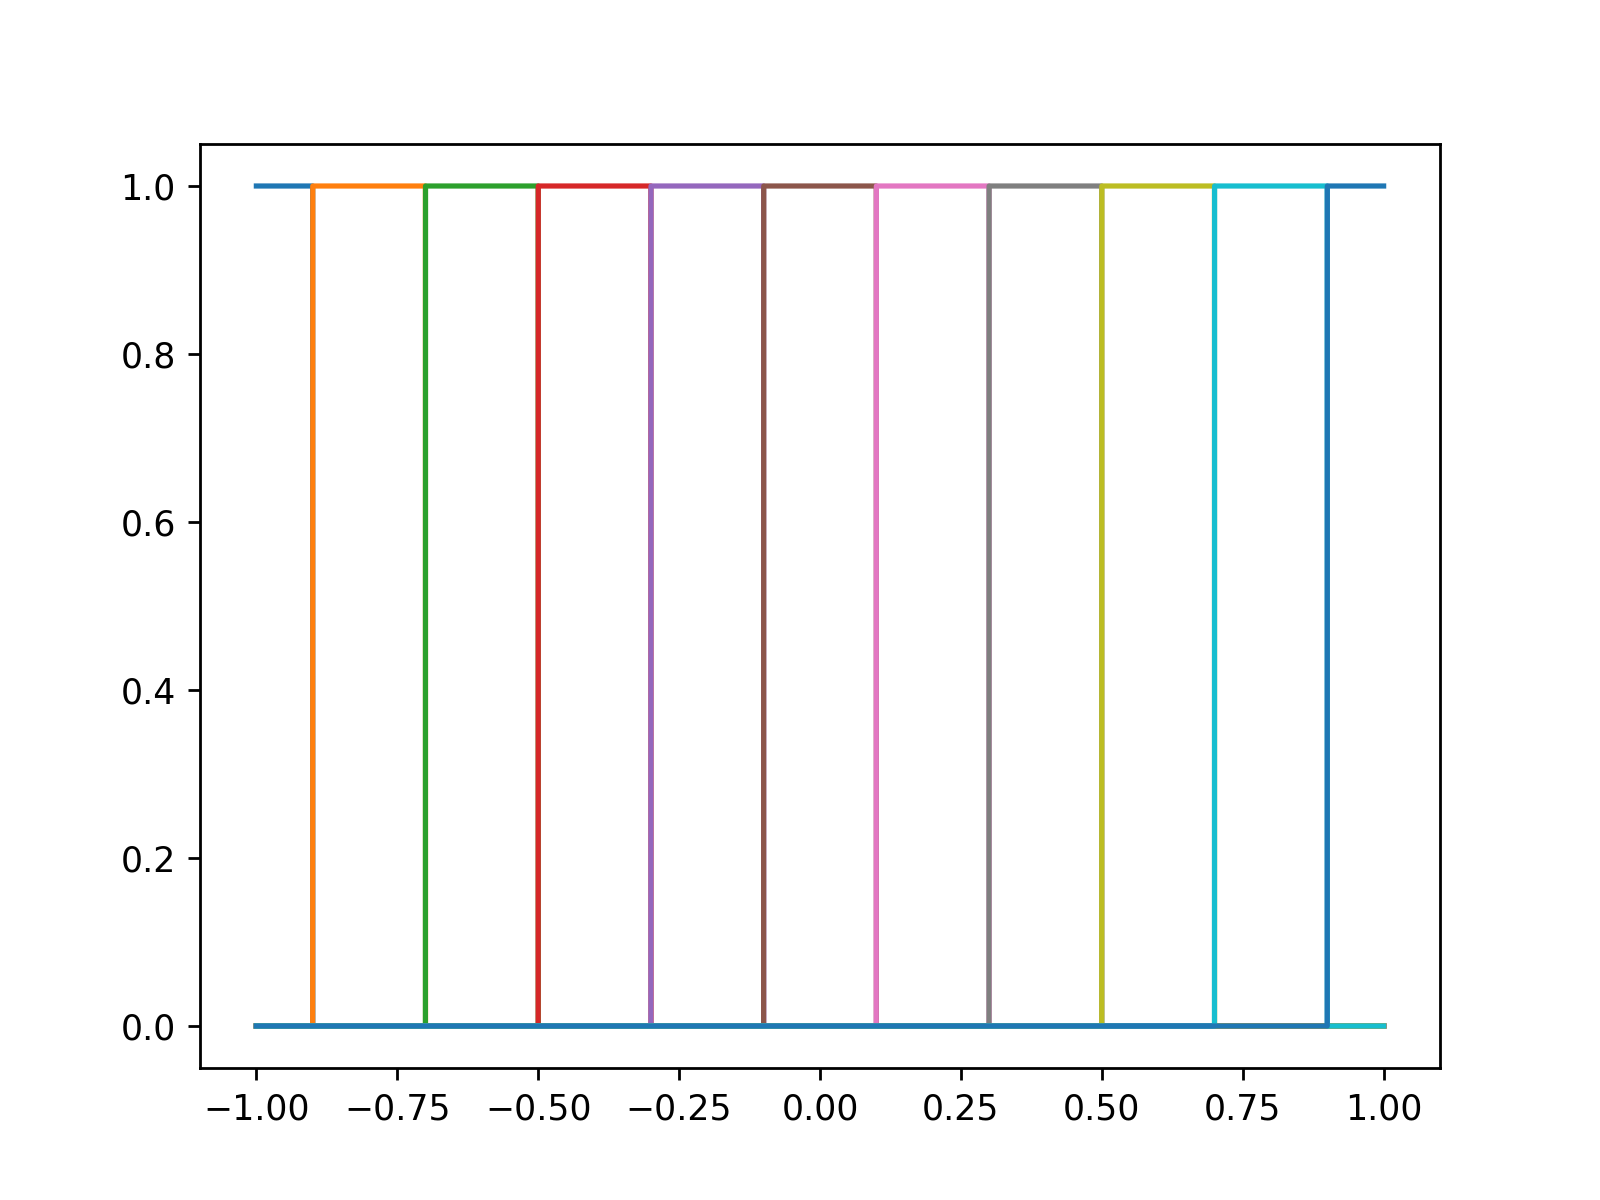

In [40]:
# Plots of the basis functions
xx = np.linspace(xleft, xright, 10*npointplot)
plt.figure()
for i in range(N):
    plt.plot(xx, phi(xx, i))
plt.show()

### System build and solve

We build the linear system and solve it:

In [41]:
# Building matrix
M = np.empty((N, N))
b = np.empty(N)
for i in range(N):
    phi_i = phi(x, i)
    b[i] = np.mean(y * phi_i)
    
    for j in range(i, N):
        M[i, j] = np.mean(phi(x, j) * phi_i)
        M[j, i] = M[i, j]

In [42]:
# solves the linear system
a = np.linalg.solve(M, b)
#a = np.linalg.lstsq(M, b, rcond=None)[0] # Use this if the system is ill-formed

<IPython.core.display.Javascript object>


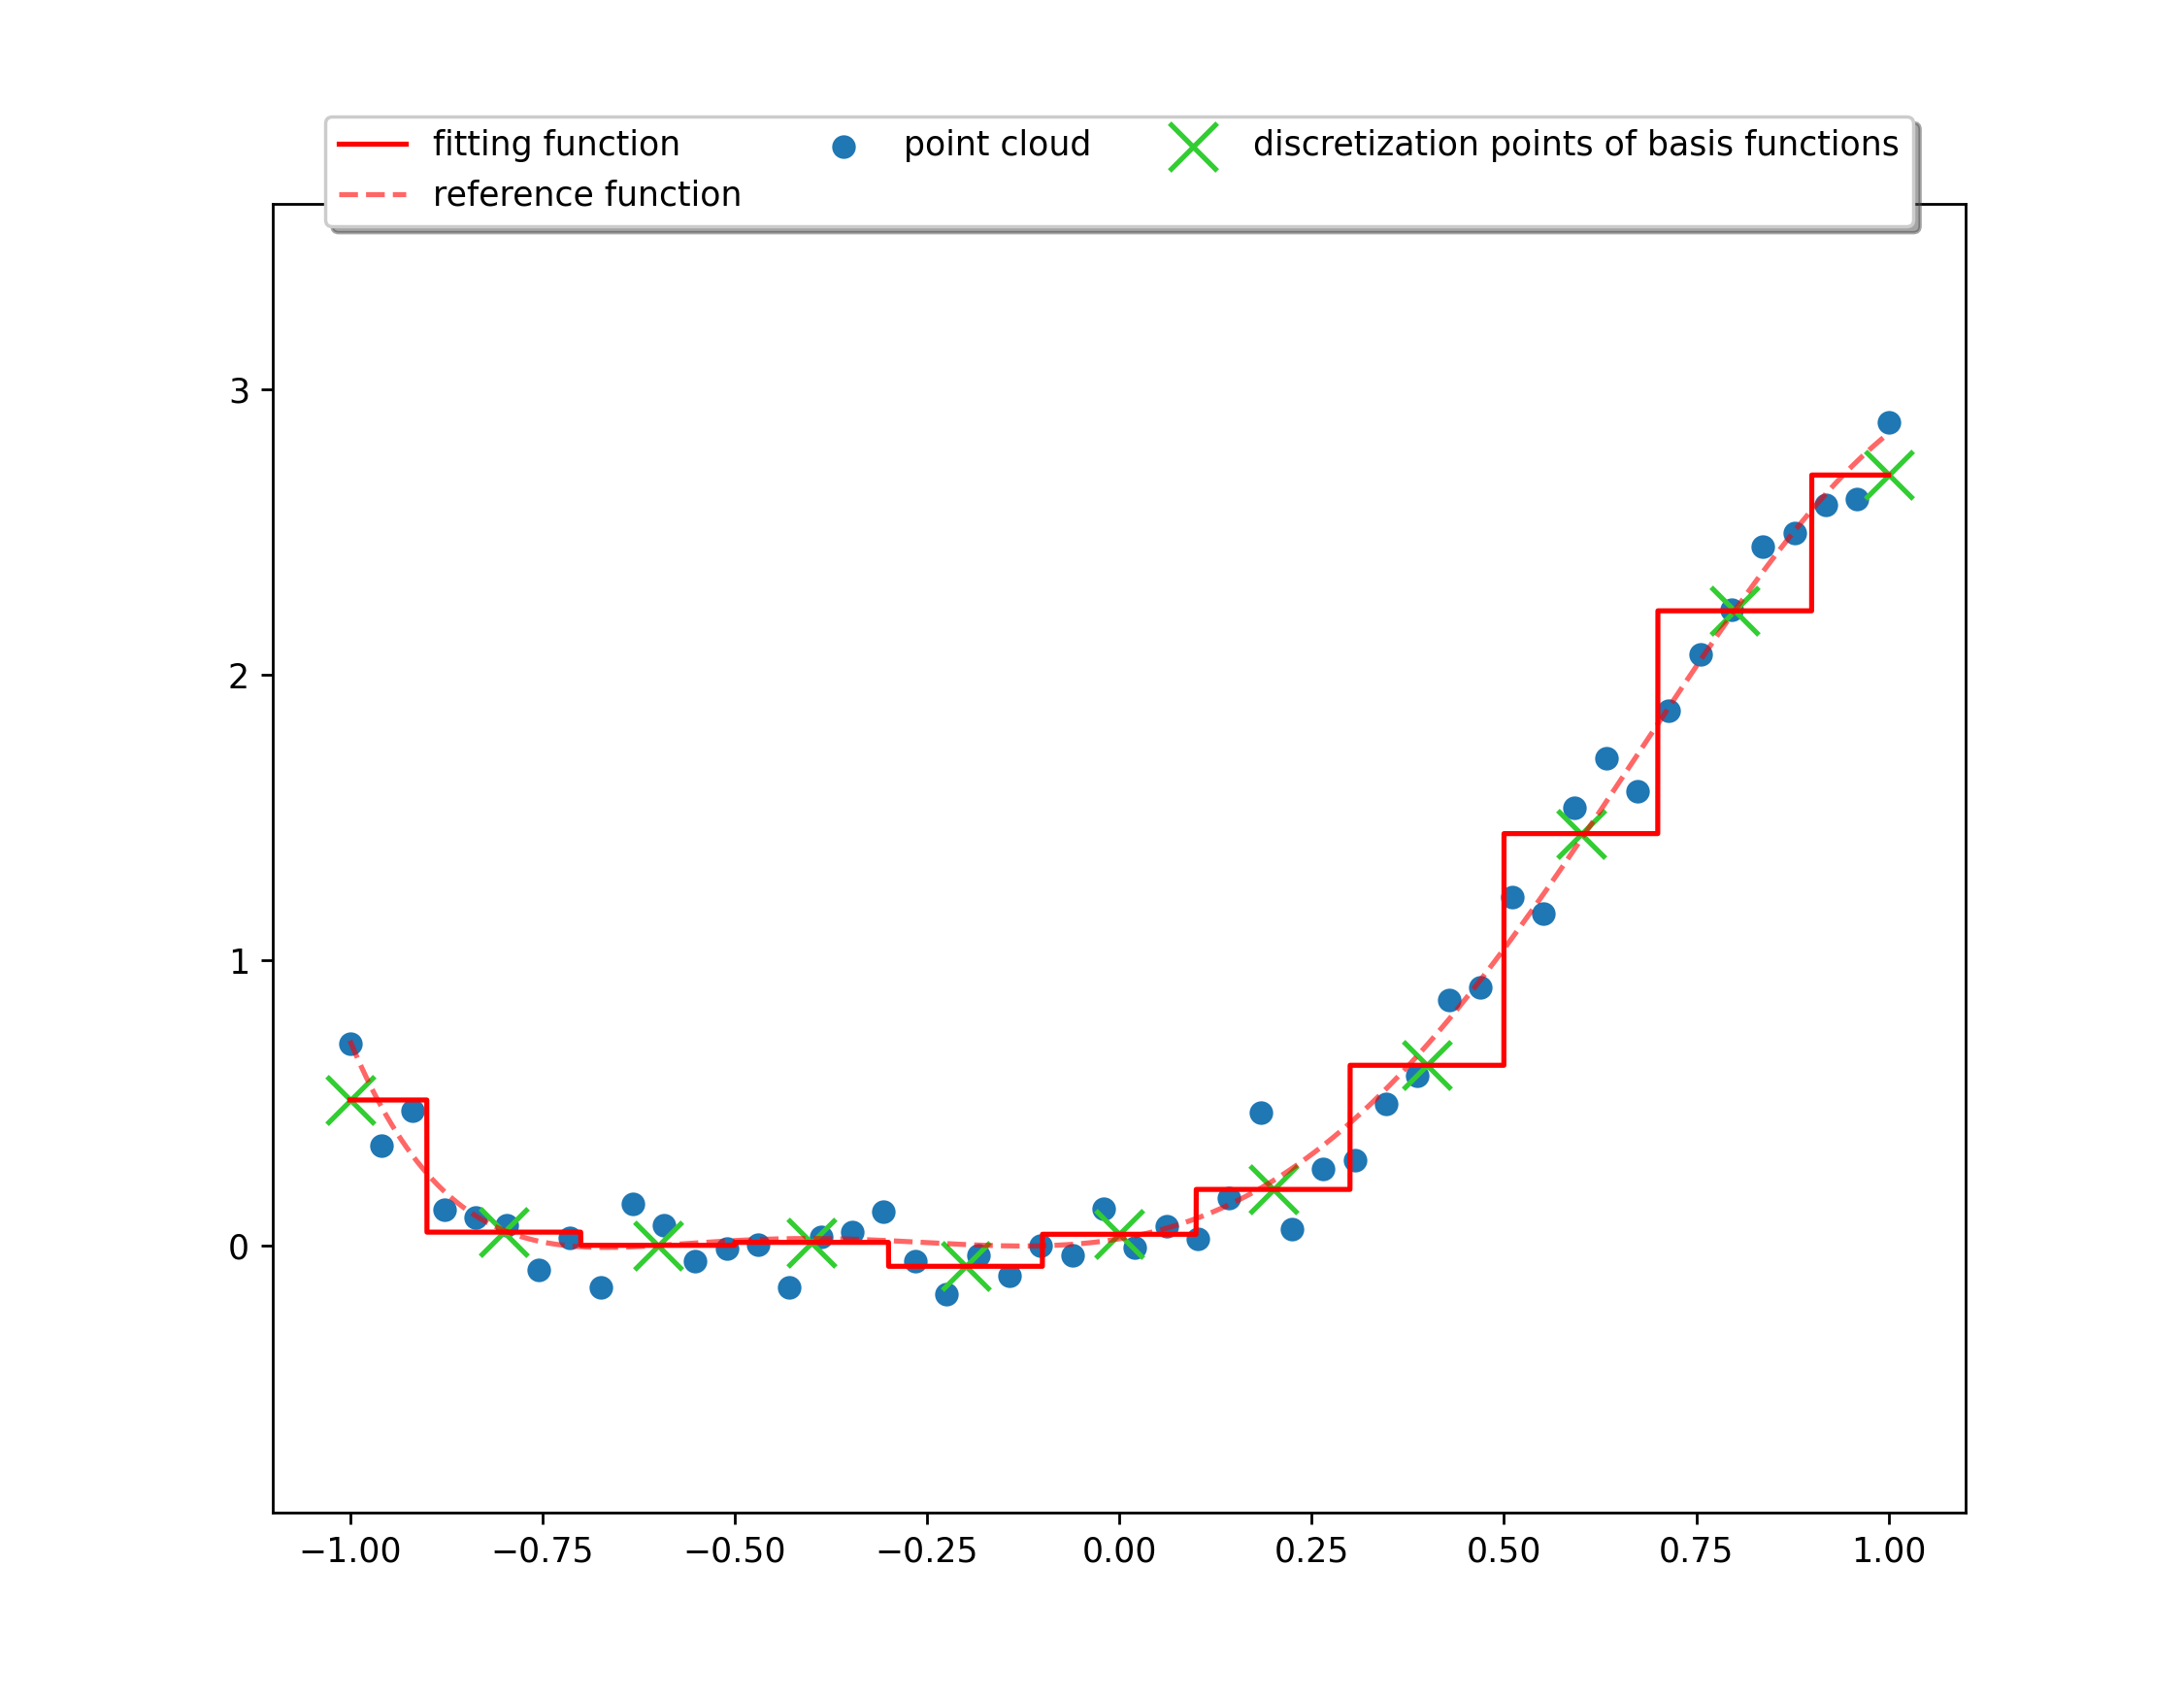

In [43]:
# Fitting function (linear combination of base functions)
def fit_func(x):
    y = np.zeros(x.shape)
    for i in range(N):
        y += a[i] * phi(x, i)
    return y

# Plots the results
cloud_max = np.amax(y)
cloud_min = np.amin(y)
margin = 0.25 * (cloud_max - cloud_min)

plt.figure(figsize=(9, 7))
plt.scatter(x, y, label="point cloud")
plt.plot(xx, fit_func(xx), 'r', label="fitting function")
plt.plot(xx, f(xx), 'r--', alpha=0.6, label='reference function')

if xphi is not None:
    plt.scatter(xphi, a, s=200, c="limegreen", marker="x", label="discretization points of basis functions")

plt.ylim(cloud_min - margin, cloud_max + margin)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=3, fancybox=True, shadow=True);

In [44]:
loss = np.linalg.norm(fit_func(xx) - f(xx))
print(f"loss = {loss}")

loss = 13.28156873004076
